# Exploratory Data Analysis

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?
2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 
3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 
4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 
5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 
6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 
7. Which lessons are least accessed? 
8. Anything else I should be aware of?


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

pd.options.display.max_columns = 15
pd.options.display.max_rows = 50

# import helper functions
import main
from acquire import get_log_data, get_cohort_data
from prepare import prep_log_cohort_data

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = prep_log_cohort_data(get_log_data(), get_cohort_data())

In [3]:
df.head().sort_index(inplace=True)

# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

Approach to answer Question 1:
1. Create separate datasets of Web Development Programs and Data Science Programs.

>Web Development: `program_id` = 1, 2, 4
> - 1 == 'Full Stack PHP'
> - 2 == 'Full Stack Java'
> - 4 == 'Front End'

>Data Science: `program_id` = 3

2. Remove common logistic pages in the curriculum e.g. '/'= Main Page), 'toc'= Table of Contents, etc.
3. Use `.value_counts()` on `page_viewed` to see the most access pages of all time. Store the top 10 page names with page counts as a variable.
4. Store the top 5 page names in a variable called `wd_top_5_pages` and `ds_top_5_pages`.



In [4]:
# Remove staff from the analysis.
df = df.loc[~(df.cohort_name == 'Staff')]

# Step 1.
# Web Devlopment Cohorts
web_dev_cohorts = df.loc[df.program_id.isin([1, 2, 4])]

# Data Science Cohorts
ds_cohorts = df.loc[df.program_id == 3]

In [5]:
# Step 2.
# Create a variable to store pages to filter out.
remove_pages = ['/', 'toc', 'appendix', 'index.html', 'search/search_index.json', 'mkdocs/search_index.json']

# Clean page_viewed to remove logistic pages: Searches, Table of Contents, Appendix
web_dev_cohorts = web_dev_cohorts.loc[~web_dev_cohorts.page_viewed.isin(remove_pages)]

# Replace content main page with empty string.
web_dev_cohorts.page_viewed = web_dev_cohorts.page_viewed.replace('content/', '', regex=True)

## Web Development Cohorts: Lesson Traffic

Web Development cohorts still in session. Cohort ID 58 == Hyperion graduated 11-10-2020. I will consider their data fully represented. They worked on capstone projects the last month of class.

In [6]:
web_dev_cohorts.head()

,page_viewed,user_id,cohort_id,ip,cohort_name,program_start,end_date,program_id
date,,,,,,,,
2018-01-26,java-ii,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2
2018-01-26,javascript-i/loops,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [7]:
# Step 3 `.value_counts()`
wd_top_10_pages = web_dev_cohorts.page_viewed.value_counts().nlargest(10)
print(wd_top_10_pages)
wd_top_10_pages = wd_top_10_pages.index.to_list()

javascript-i     12639
java-iii          9702
html-css          9675
java-ii           9072
spring            8785
jquery            8298
mysql             8180
java-i            8075
javascript-ii     7623
mysql/tables      5730
Name: page_viewed, dtype: int64


In [8]:
wd_top_5_pages = wd_top_10_pages[:5]

print(f'Top 5 pages accessed by users in Web Devlopement:')
print('-' * 49)
for i in wd_top_5_pages:
    print(i)

Top 5 pages accessed by users in Web Devlopement:
-------------------------------------------------
javascript-i
java-iii
html-css
java-ii
spring


In [9]:
# Create a dataframe of the top 5 pages accessed. Sum the total views for each day.
wd_pages_over_time = web_dev_cohorts.groupby(['date', 'page_viewed'])['user_id'].count().unstack(1)
wd_pages_over_time = wd_pages_over_time.fillna(0)

wd_top_5_pages_over_time = wd_pages_over_time[wd_top_5_pages]
wd_top_5_pages_over_time.head()

page_viewed,javascript-i,java-iii,html-css,java-ii,spring
date,,,,,
2018-01-26,14.0,0.0,2.0,1.0,23.0
2018-01-27,10.0,0.0,5.0,0.0,10.0
2018-01-28,9.0,2.0,4.0,0.0,4.0
2018-01-29,36.0,6.0,14.0,0.0,36.0
2018-01-30,43.0,0.0,6.0,1.0,17.0


In [10]:
# Web Development: Monthly average page views per page
wd_top_5_pages_over_time.resample('M').sum().mean()

page_viewed
javascript-i    361.114286
java-iii        277.200000
html-css        276.428571
java-ii         259.200000
spring          251.000000
dtype: float64

Exponential Weighted Mean used for several reasons.
1. There are multiple Web Development cohorts in session at a time.
    - Sessions in San Antonio and Dallas.
2. In 2020, there were 3 cohorts that started one month apart: Fortuna, Apex, Ganymede.
    - Fortuna, Apex, Ganymede have graduated.

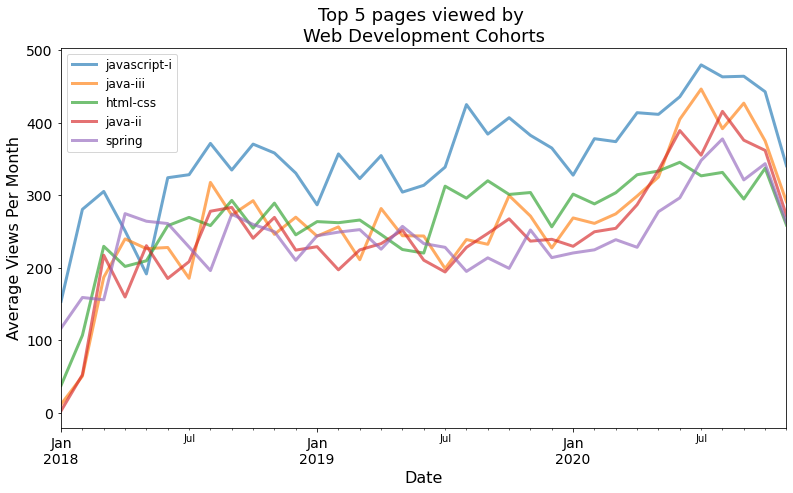

In [11]:
wd_top_5_pages_ewm = wd_top_5_pages_over_time.resample('M').sum().ewm(3).mean()

ax = wd_top_5_pages_ewm.plot(figsize=(13, 7), linewidth=3, use_index=True, alpha=.65)

plt.title('Top 5 pages viewed by \nWeb Development Cohorts', fontsize=18)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Views Per Month', fontsize=16)

ax.legend(*[wd_top_5_pages],fontsize=12);

Question 1, Part 1:<br>
Which lesson appears to attract the most traffic consistently across cohorts (Web Development Programs)?<br>
>Answer: Web development cohorts access <strong>javascript-i</strong> the most.

## Data Science Cohorts: Lesson Traffic

In [12]:
# Step 2.
# Create a variable to store pages to filter out.
remove_pages = ['/', 'toc', 'appendix', 'index.html', 'search/search_index.json', 'mkdocs/search_index.json']

# Clean page_viewed to remove logistic pages: Searches, Table of Contents, Appendix
ds_cohorts = ds_cohorts.loc[~ds_cohorts.page_viewed.isin(remove_pages)]

# Replace content main page with empty string.
ds_cohorts.page_viewed = ds_cohorts.page_viewed.replace('content/', '', regex=True)

In [13]:
ds_cohorts.head()

,page_viewed,user_id,cohort_id,ip,cohort_name,program_start,end_date,program_id
date,,,,,,,,
2019-08-20,3-sql/1-mysql-overview,470,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2-storytelling/bad-charts,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2-storytelling/misleading1_baseball.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2-storytelling/misleading1_fox.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,2-storytelling/misleading3_deaths.jpg,467,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3


In [14]:
# Step 3 `.value_counts()`
ds_top_10_pages = ds_cohorts.page_viewed.value_counts().nlargest(10)
print(ds_top_10_pages)
ds_top_10_pages = ds_top_10_pages.index.to_list()

1-fundamentals/modern-data-scientist.jpg             1563
1-fundamentals/AI-ML-DL-timeline.jpg                 1559
1-fundamentals/1.1-intro-to-data-science             1536
6-regression/1-overview                              1123
classification/overview                               860
10-anomaly-detection/AnomalyDetectionCartoon.jpeg     745
10-anomaly-detection/1-overview                       742
3-sql/1-mysql-overview                                704
1-fundamentals/DataToAction_v2.jpg                    662
classification/scale_features_or_not.svg              642
Name: page_viewed, dtype: int64


In [15]:
ds_top_5_pages = ds_top_10_pages[:5]
print(f'Top 5 pages accessed by users in Data Science:')
print('-' * 46)
for i in ds_top_5_pages:
    print(i)

Top 5 pages accessed by users in Data Science:
----------------------------------------------
1-fundamentals/modern-data-scientist.jpg
1-fundamentals/AI-ML-DL-timeline.jpg
1-fundamentals/1.1-intro-to-data-science
6-regression/1-overview
classification/overview


In [16]:
ds_pages_over_time = ds_cohorts.groupby(['date', 'page_viewed'])['user_id'].count().unstack(1)
ds_pages_over_time = ds_pages_over_time.fillna(0)

ds_top_5_pages_over_time = ds_pages_over_time[ds_top_5_pages]
ds_top_5_pages_over_time.head()

page_viewed,1-fundamentals/modern-data-scientist.jpg,1-fundamentals/AI-ML-DL-timeline.jpg,1-fundamentals/1.1-intro-to-data-science,6-regression/1-overview,classification/overview
date,,,,,
2019-08-20,46.0,46.0,45.0,0.0,0.0
2019-08-21,74.0,73.0,71.0,23.0,0.0
2019-08-22,41.0,40.0,40.0,12.0,0.0
2019-08-23,9.0,9.0,9.0,0.0,0.0
2019-08-24,3.0,3.0,3.0,1.0,0.0


In [17]:
# Data Science: Monthly average page views per page
ds_top_5_pages_over_time.resample('M').sum().mean()

page_viewed
1-fundamentals/modern-data-scientist.jpg    97.6875
1-fundamentals/AI-ML-DL-timeline.jpg        97.4375
1-fundamentals/1.1-intro-to-data-science    96.0000
6-regression/1-overview                     70.1875
classification/overview                     53.7500
dtype: float64

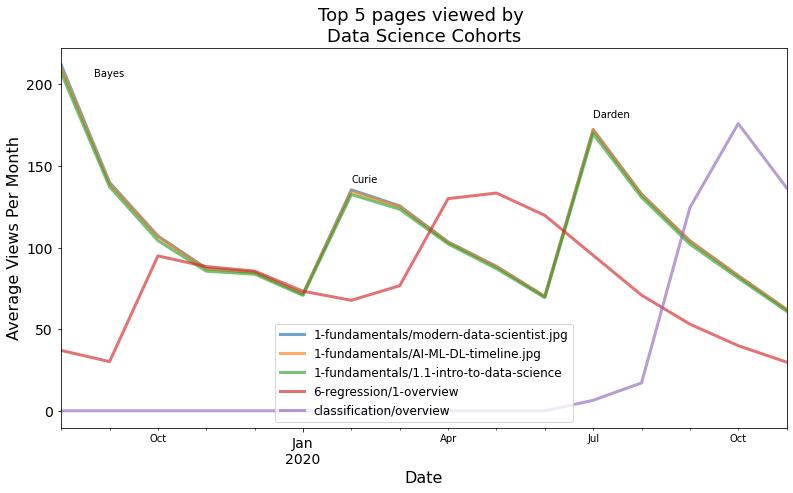

In [18]:
ds_top_5_pages_ewm = ds_top_5_pages_over_time.resample('M').sum().ewm(3).mean()

ax = ds_top_5_pages_ewm.plot(figsize=(13, 7), linewidth=3, use_index=True, alpha=.65)

plt.title('Top 5 pages viewed by \nData Science Cohorts', fontsize=18)
plt.tick_params(labelsize=14, pad=5)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Views Per Month', fontsize=16)

ax.legend(*[ds_top_5_pages], fontsize=12, loc=8)
ax.text('2019-09-01', 205, 'Bayes', ha='center')
ax.text('2020-02-01', 140, 'Curie')
ax.text('2020-07-01', 180, 'Darden');

Question 1, Part 2:<br>
Which lesson appears to attract the most traffic consistently across cohorts (Data Science Programs)?<br>
>Answer: Data Science cohorts access <strong>1-fundamentals/modern-data-science.jpg</strong> the most.

Answer:
Among all cohorts, web dev and data science, introductory curriculum pages are accessed the most.
- There are more students at the start of a cohort. Students may drop out.

# 2. Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 

## Web Development
Question 2, Part 1<br>
Is there a web development cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

To answer this question, we'll focus on cohorts that graduated in 2020.

| cohort_id | cohort_name  | program_start_date | end_date |
| :-------- | :---------- | :----------------- | :------- |
51	| Deimos	| 2019-09-16 |	2020-02-27 |
52	| Europa	| 2019-11-04 |	2020-04-17 |
53	| Fortuna	| 2020-01-13 |	2020-06-23 |
56	| Apex	| 2020-02-24 |	2020-07-29 |
57	| Ganymede	| 2020-03-23 |	2020-08-20 |
58	| Hyperion	| 2020-05-26 |	2020-11-10 |

In [19]:
wd_recent_grads = web_dev_cohorts.loc[web_dev_cohorts.cohort_id.isin([51,52,53,56,57,58])]
wd_recent_grads.head()

,page_viewed,user_id,cohort_id,ip,cohort_name,program_start,end_date,program_id
date,,,,,,,,
2019-09-16,html-css,489,51,97.105.19.58,Deimos,2019-09-16,2020-02-27,2
2019-09-16,javascript-i,489,51,97.105.19.58,Deimos,2019-09-16,2020-02-27,2
2019-09-16,html-css,489,51,97.105.19.58,Deimos,2019-09-16,2020-02-27,2
2019-09-16,html-css,489,51,97.105.19.58,Deimos,2019-09-16,2020-02-27,2
2019-09-16,html-css,490,51,97.105.19.58,Deimos,2019-09-16,2020-02-27,2


<div class='alert alert-box alert-info'>Each bar represents the number of times a cohort has viewed a page of the curriculum. The page viewed is the title. The graphs are ordered from most viewed page to 10th most viewed page. Read Left to Right.</div>

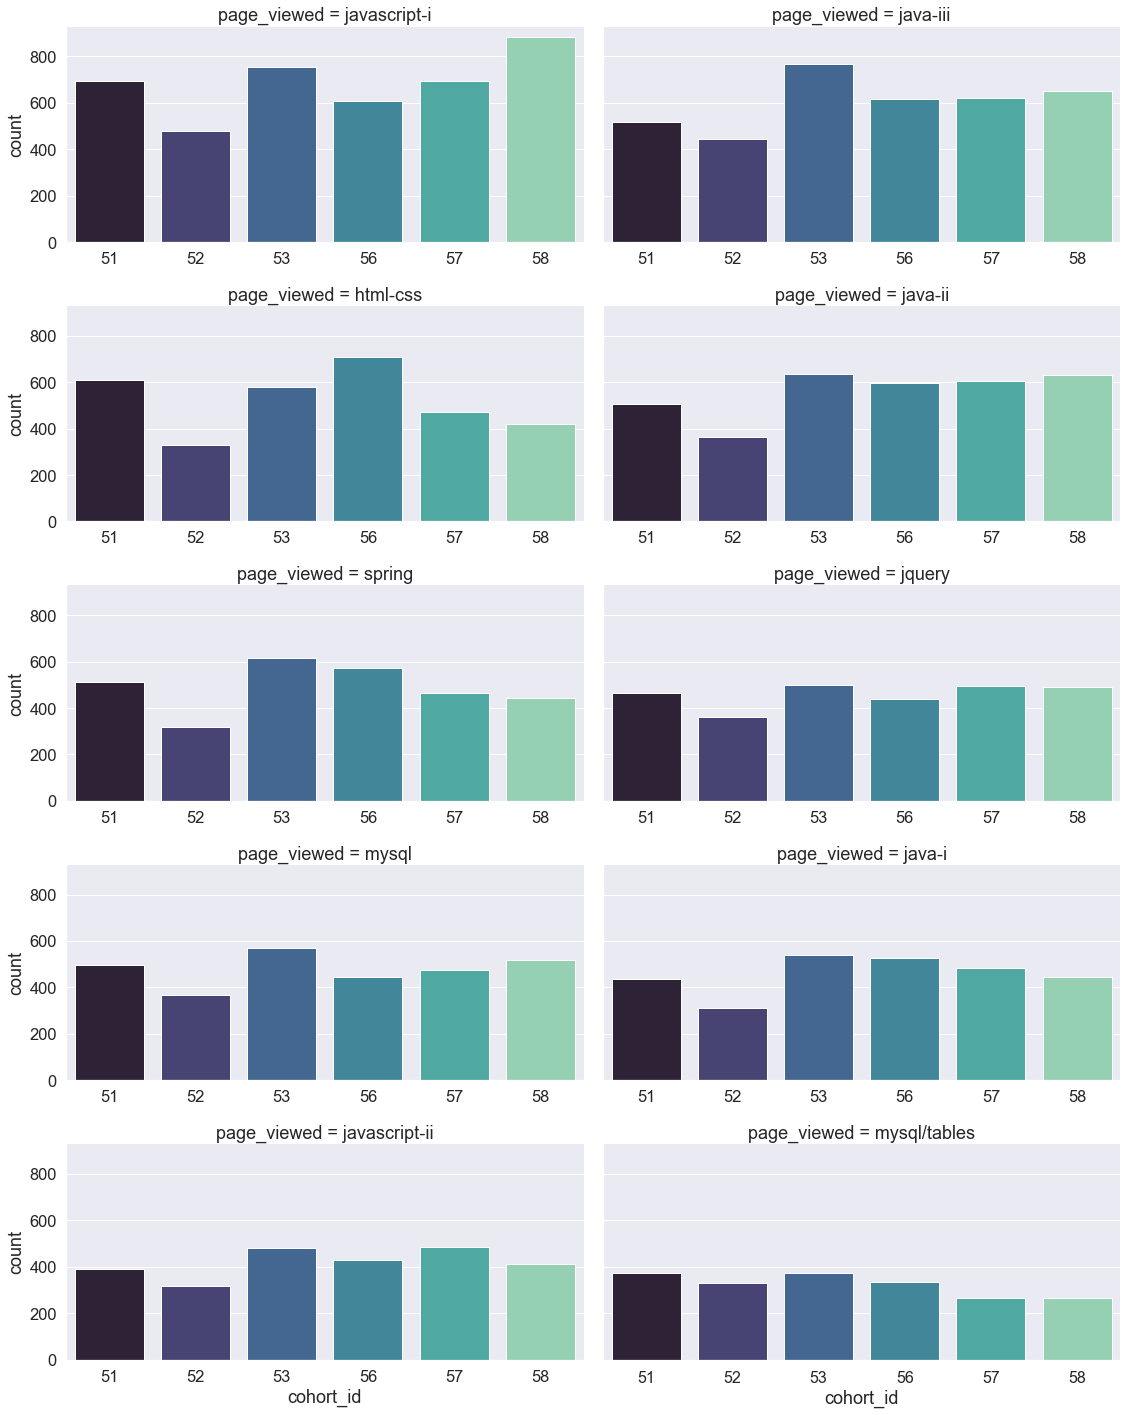

In [20]:
sns.set(font_scale = 1.5)
row_order=wd_top_10_pages

g = sns.catplot(data=wd_recent_grads,
                x="cohort_id",
                kind="count",
                col="page_viewed",
                col_order=wd_top_10_pages,
                col_wrap=2,
                height=4,
                aspect=2,
                sharex=False,
                palette='mako')

plt.tick_params(labelsize=16, pad=5)
plt.tight_layout();

Question 2, Part 1<br>
Is there a web development cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

1. Ganymede cohort viewed javascript-i more than the other cohorts.
1. Fortuna cohort viewed java-iii more than the other cohorts.
1. Apex cohort viewed html-css more than the other cohorts.
1. Hyperion viewed html-css less than the other cohorts.
1. Decline in `spring`, `java-i`, and `mysql/tables` page views across cohorts.


## Data Science: Top 10 Lesson Across Cohorts


In [21]:
# Filter the data science dataset for observations with the 10 ten pages
ds_data = ds_cohorts.loc[ds_cohorts.page_viewed.isin(ds_top_10_pages)]
ds_data.head()

,page_viewed,user_id,cohort_id,ip,cohort_name,program_start,end_date,program_id
date,,,,,,,,
2019-08-20,3-sql/1-mysql-overview,470,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/1.1-intro-to-data-science,469,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/modern-data-scientist.jpg,469,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/AI-ML-DL-timeline.jpg,469,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3
2019-08-20,1-fundamentals/1.1-intro-to-data-science,480,34,97.105.19.58,Bayes,2019-08-19,2020-01-30,3


<div class='alert alert-box alert-info'>Each bar represents the number of times a cohort has viewed a page of the curriculum. The page viewed is the title. The graphs are ordered from most viewed page to 10th most viewed page. Read Left to Right</div>

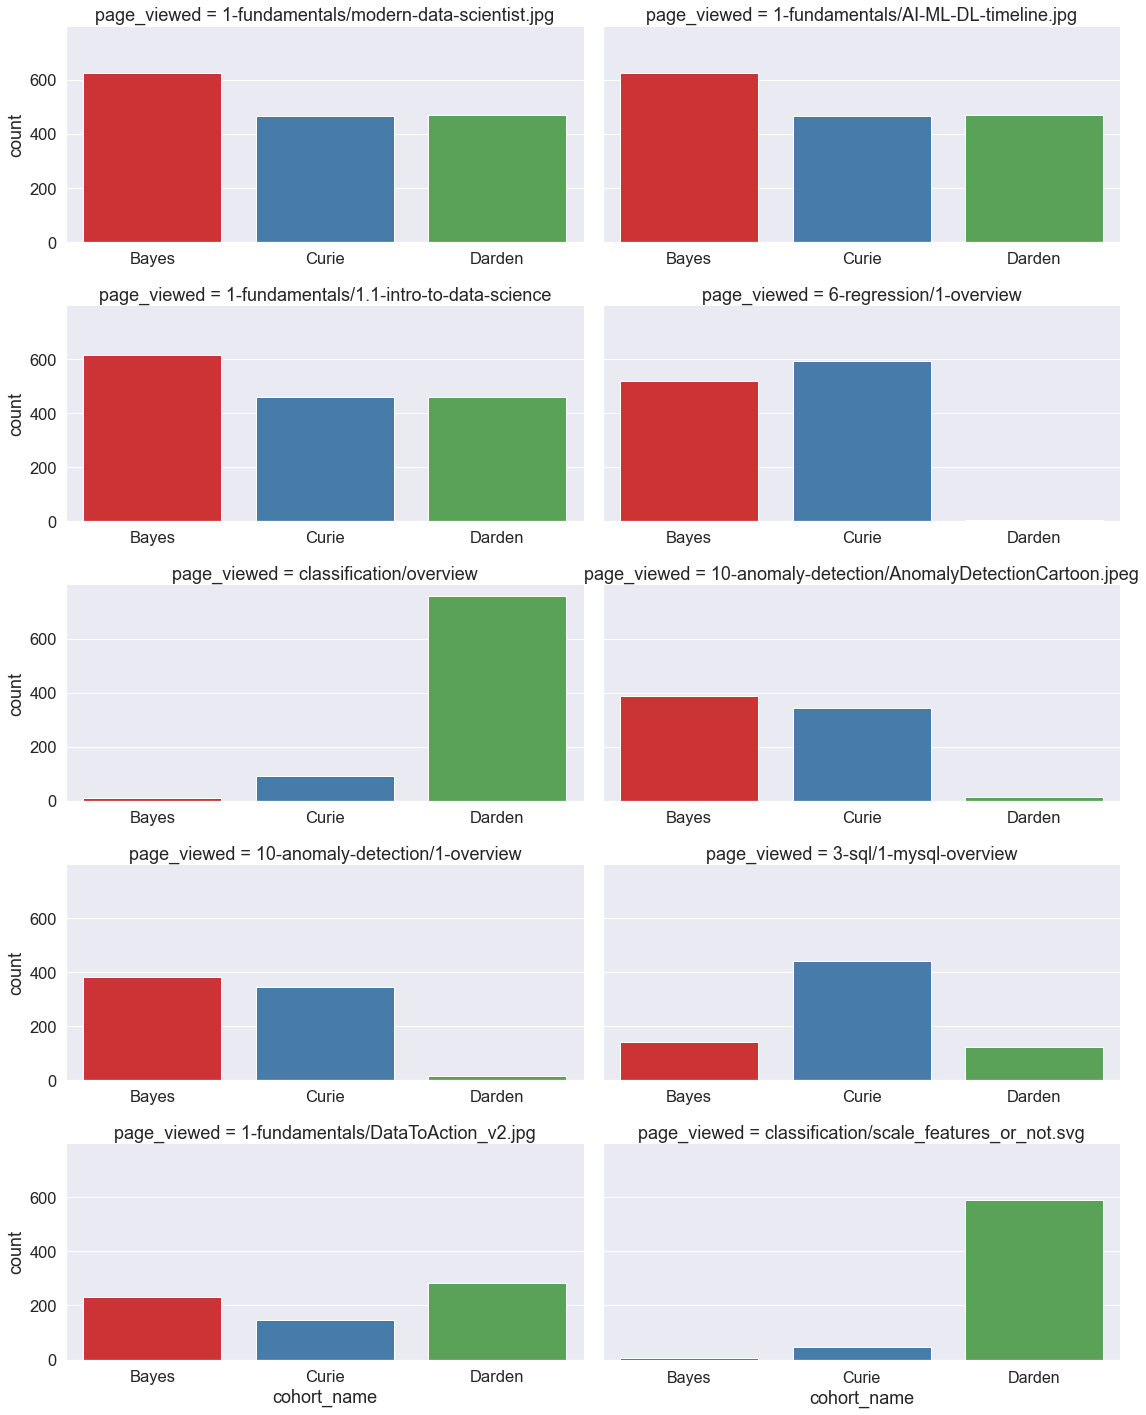

In [22]:
sns.set(font_scale = 1.5)
column_order=ds_top_10_pages

g = sns.catplot(data=ds_data,
                x="cohort_name",
                kind="count",
                col="page_viewed",
                col_order=column_order,
                order=['Bayes', 'Curie', "Darden"],
                col_wrap=2,
                height=4,
                aspect=2,
                sharex=False,
                palette='Set1')

plt.tick_params(labelsize=16, pad=5)
plt.tight_layout();

Question 2, Part 1<br>
Is there a web data science cohort that referred to a lesson significantly more that other cohorts seemed to gloss over?

1. Bayes viewed `1-fundamentals/modern-data-scientist.jpg`, `1-fundamentals/AI-ML-DL-timeline.jpg`, and `1-fundamentals/1.1-intro-to-data-science` more than the other cohorts.
1. Bayes and Curie viewed `6-regression/1-overview` more than Darden. Darden has almost no page views. This may have been a time when Maggie used her iPad to teach the curriculum.
1. Darden viewed `classification/overview` significantly more than Bayes and Curie.
1. Bayes and Curie viewed `10-anomaly-detection/AnomalyDetectionCartoon.jpeg` and `10-anomaly-detection/1-overview` significantly more than Darden. This may have also been a time when Maggie used her iPad to teach the curriculum. 
1. Curie viewed `3-sql/1-mysql-overview` significantly more than the other cohorts.
1. Darden viewed `classification/scale_features_or_not.svg` significantly more than the other cohorts.

# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 

In [23]:
df = prep_log_cohort_data(get_log_data(), get_cohort_data(), explore=True)
remove_pages = ['/', 'toc', 'appendix', 'index.html', 'search/search_index.json', 'mkdocs/search_index.json']

# Clean page_viewed to remove logistic pages: Searches, Table of Contents, Appendix
df = df.loc[~df.page_viewed.isin(remove_pages)]
df = df.loc[~(df.cohort_name == 'Staff')]
current_students = df.loc[df.has_graduated == 0]

In [24]:
# Active Web Development Students
wd_bash = current_students.loc[current_students.cohort_id == 61]
wd_jupiter = current_students.loc[current_students.cohort_id == 62]

# Active Data Science Students
ds_darden = current_students.loc[current_students.cohort_id == 59]

# Current Web Development Students

## Bash

In [25]:
wd_bash.head()

,page_viewed,user_id,cohort_id,ip,cohort_name,program_start,end_date,...,last_access,days_with_access,active_within_5_days,active_within_1_month,active_within_3_months,active_within_6_months,active_greater_than_6_months
date,,,,,,,,,,,,,,,
2020-07-20,html-css,700,61,99.43.143.116,Bash,2020-07-20,2021-01-21,...,2020-10-23,95,0,1,0,0,0
2020-07-21,html-css,700,61,99.43.143.116,Bash,2020-07-20,2021-01-21,...,2020-10-23,95,0,1,0,0,0
2020-07-21,web-dev-day-two,700,61,99.43.143.116,Bash,2020-07-20,2021-01-21,...,2020-10-23,95,0,1,0,0,0
2020-07-21,web-dev-day-two,700,61,99.43.143.116,Bash,2020-07-20,2021-01-21,...,2020-10-23,95,0,1,0,0,0
2020-07-21,appendix/pair-programming,700,61,99.43.143.116,Bash,2020-07-20,2021-01-21,...,2020-10-23,95,0,1,0,0,0


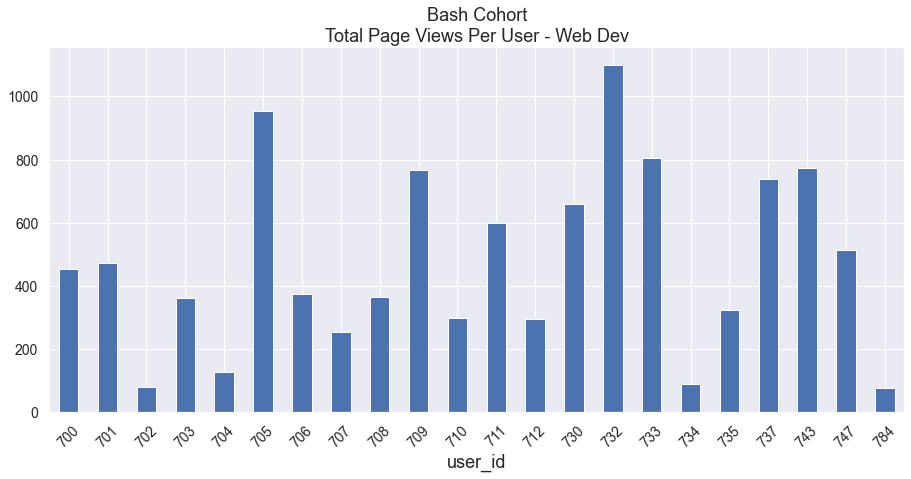

In [26]:
wd_bash.groupby('user_id').page_viewed.count().plot(kind='bar', figsize=(13, 7), rot=45)

plt.tick_params(labelsize=14, pad=5)
plt.title('Bash Cohort\nTotal Page Views Per User - Web Dev')
plt.tight_layout();

Bash Cohort Deep Dive
- Greater than 800
- Less than 200
- Users 705, 732, 733

In [27]:
# Filter Bash IDs
bash_upper_ids = wd_bash.groupby('user_id').page_viewed.count()[wd_bash.groupby('user_id').page_viewed.count() > 800].index.to_list()
bash_lower_ids = wd_bash.groupby('user_id').page_viewed.count()[wd_bash.groupby('user_id').page_viewed.count() < 200].index.to_list()

In [28]:
# Users with greater than 800 page views
bash_upper = wd_bash.loc[wd_bash.user_id.isin(bash_upper_ids)]
bash_upper.groupby(by=['user_id', 'last_access']).size()

user_id  last_access
705      2020-11-02      955
732      2020-11-02     1100
733      2020-11-02      805
dtype: int64

In [29]:
# Users with less than 200 page views
bash_lower = wd_bash.loc[wd_bash.user_id.isin(bash_lower_ids)]
bash_lower.groupby(by=['user_id', 'last_access']).size()

user_id  last_access
702      2020-08-03      78
704      2020-11-02     127
734      2020-08-31      90
784      2020-11-02      75
dtype: int64

### User 705

In [30]:
user_705 = wd_bash.loc[wd_bash.user_id==705]
user_705.page_viewed.value_counts().nlargest(10)

appendix/extra-challenges/basic-challenges    43
jquery                                        30
javascript-i                                  30
javascript-ii                                 27
html-css/css-ii/bootstrap-introduction        20
javascript-i/arrays/manipulating              17
javascript-i/arrays                           17
jquery/selectors                              15
java-i/methods                                15
java-ii                                       15
Name: page_viewed, dtype: int64

In [31]:
user_705.nunique()

page_viewed                     149
user_id                           1
cohort_id                         1
ip                                2
cohort_name                       1
program_start                     1
end_date                          1
program_id                        1
program_type                      1
has_graduated                     1
first_access                      1
last_access                       1
days_with_access                  1
active_within_5_days              1
active_within_1_month             1
active_within_3_months            1
active_within_6_months            1
active_greater_than_6_months      1
dtype: int64

### User 732

In [32]:
user_732 = wd_bash.loc[wd_bash.user_id==732]
user_732.page_viewed.value_counts().nlargest(10)

javascript-i/introduction                 132
java-ii                                    33
jquery                                     23
html-css/css-ii/bootstrap-grid-system      21
javascript-i                               21
html-css/css-ii/bootstrap-introduction     19
javascript-ii/promises                     17
java-ii/object-oriented-programming        17
java-i                                     17
html-css                                   17
Name: page_viewed, dtype: int64

In [33]:
user_732.nunique()

page_viewed                     146
user_id                           1
cohort_id                         1
ip                                1
cohort_name                       1
program_start                     1
end_date                          1
program_id                        1
program_type                      1
has_graduated                     1
first_access                      1
last_access                       1
days_with_access                  1
active_within_5_days              1
active_within_1_month             1
active_within_3_months            1
active_within_6_months            1
active_greater_than_6_months      1
dtype: int64

### User 733

In [34]:
user_733 = wd_bash.loc[wd_bash.user_id==733]
user_733.page_viewed.value_counts().nlargest(10)

jquery                                   22
examples/css/css_selectors.html          22
java-i/control-statements-and-loops      18
html-css/css-ii/bootstrap-grid-system    17
javascript-i                             15
mysql/databases                          15
mysql                                    15
java-ii/arrays                           15
java-i/syntax-types-and-variables        14
java-ii                                  14
Name: page_viewed, dtype: int64

In [35]:
user_733.nunique()

page_viewed                     137
user_id                           1
cohort_id                         1
ip                                9
cohort_name                       1
program_start                     1
end_date                          1
program_id                        1
program_type                      1
has_graduated                     1
first_access                      1
last_access                       1
days_with_access                  1
active_within_5_days              1
active_within_1_month             1
active_within_3_months            1
active_within_6_months            1
active_greater_than_6_months      1
dtype: int64

In [36]:
user_733.groupby('ip').size()

ip
104.219.136.34    613
107.77.217.201      4
107.77.217.231      7
107.77.217.70       2
107.77.220.169     34
107.77.220.6       12
107.77.221.209     30
107.77.222.142      1
66.90.156.125     102
dtype: int64

### Bash Users Review
1. Users 78 and 90 must have dropped the course.
2. Nothing out of the ordinary with users 705 and 732.
3. User 705 is doing extra credit. They've accessed `appendix/extra-challenges/basic-challenges` 43 times.
4. User 733 has 9 ip addresses:
    1. San Antonio ip 66.90.156.125
    2. Atascosa (South of San Antonio) ip 104.219.136.34
    3. The rest mobile hotspots with a Houston Area Code.
>    Everything checks out

## Jupiter

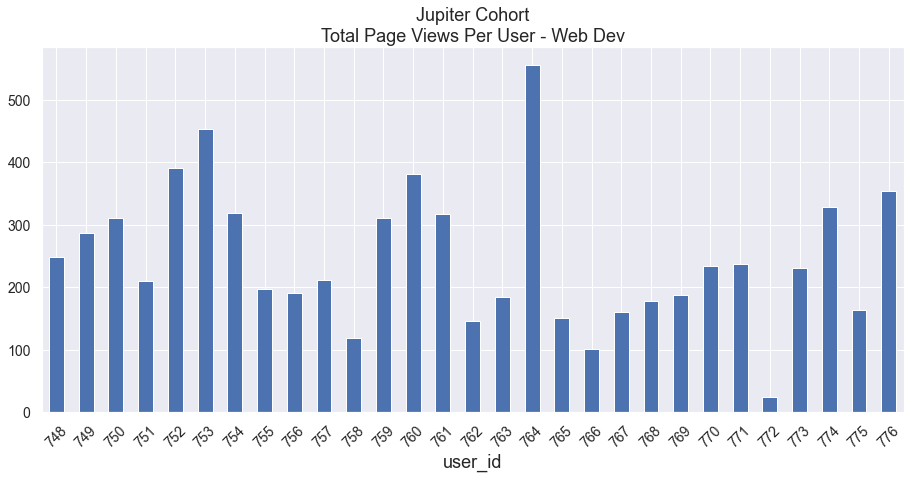

In [37]:
wd_jupiter.groupby('user_id').page_viewed.count().plot(kind='bar', figsize=(13, 7), rot=45)

plt.tick_params(labelsize=14, pad=5)
plt.title('Jupiter Cohort\nTotal Page Views Per User - Web Dev')
plt.tight_layout();

Jupiter Cohort Deep Dive
- Greater than 400
- Less than 200
- Users 753 and 764

In [38]:
jup_upper_ids = wd_jupiter.groupby('user_id').page_viewed.count()[wd_jupiter.groupby('user_id').page_viewed.count() > 300].index.to_list()
jup_lower_ids = wd_jupiter.groupby('user_id').page_viewed.count()[wd_jupiter.groupby('user_id').page_viewed.count() < 150].index.to_list()

In [39]:
# Users with more than 400 page views
jup_upper = wd_jupiter.loc[wd_jupiter.user_id.isin(jup_upper_ids)]
jup_upper.groupby(by=['user_id', 'last_access']).size()

user_id  last_access
750      2020-11-02     311
752      2020-10-26     391
753      2020-11-02     453
754      2020-11-02     318
759      2020-11-02     310
760      2020-11-02     382
761      2020-11-02     317
764      2020-11-02     556
774      2020-11-02     329
776      2020-11-02     354
dtype: int64

In [40]:
# Users with less than 200 page views
jup_lower = wd_jupiter.loc[wd_jupiter.user_id.isin(jup_lower_ids)]
jup_lower.groupby(by=['user_id', 'last_access']).size()

user_id  last_access
758      2020-10-21     119
762      2020-11-02     146
766      2020-11-02     101
772      2020-09-23      24
dtype: int64

#### User 753

In [41]:
user_753 = wd_jupiter.loc[wd_jupiter.user_id==753]
user_753.page_viewed.value_counts().nlargest(10)

javascript-i                               48
html-css                                   41
javascript-i/functions                     25
html-css/css-i/selectors-and-properties    19
html-css/css-ii/bootstrap-grid-system      18
html-css/css-i/box-model                   18
javascript-i/arrays                        18
javascript-i/arrays/manipulating           17
html-css/css-ii/media-queries              16
javascript-i/conditionals                  16
Name: page_viewed, dtype: int64

In [42]:
user_753.nunique()

page_viewed                     65
user_id                          1
cohort_id                        1
ip                               2
cohort_name                      1
program_start                    1
end_date                         1
program_id                       1
program_type                     1
has_graduated                    1
first_access                     1
last_access                      1
days_with_access                 1
active_within_5_days             1
active_within_1_month            1
active_within_3_months           1
active_within_6_months           1
active_greater_than_6_months     1
dtype: int64

#### User 764

In [43]:
user_764 = wd_jupiter.loc[wd_jupiter.user_id==764]
user_764.page_viewed.value_counts().nlargest(10)

html-css/css-ii/bootstrap-introduction                                       37
javascript-i/javascript-with-html                                            30
html-css/css-ii/media-queries                                                26
javascript-i/introduction/working-with-data-types-operators-and-variables    26
html-css/css-ii/bootstrap-grid-system                                        26
html-css/elements                                                            23
html-css/css-i/flexbox/flexbox-fundamentals                                  20
html-css/css-i/positioning                                                   19
html-css/forms                                                               19
javascript-i/functions                                                       18
Name: page_viewed, dtype: int64

In [44]:
user_764.nunique()

page_viewed                     71
user_id                          1
cohort_id                        1
ip                               3
cohort_name                      1
program_start                    1
end_date                         1
program_id                       1
program_type                     1
has_graduated                    1
first_access                     1
last_access                      1
days_with_access                 1
active_within_5_days             1
active_within_1_month            1
active_within_3_months           1
active_within_6_months           1
active_greater_than_6_months     1
dtype: int64

### Jupiter Users Review
1. Naturally users with more views access the curriculum more.
2. Users 772 and 758 may have dropped the course.
3. Users 753 and 764 access javascript and html-css pages the most. Check projects, quiz grades, and github repository for comprehension.

# Current Data Science Students

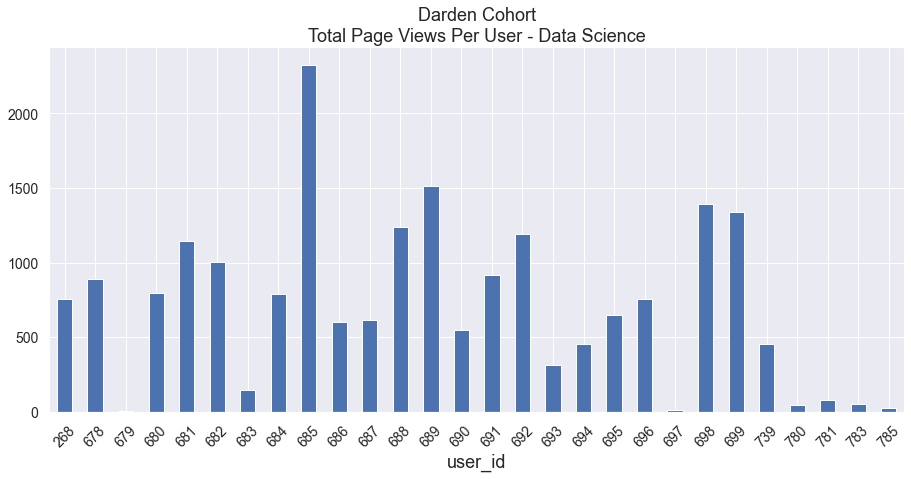

In [45]:
ds_darden.groupby('user_id').page_viewed.count().plot(kind='bar', figsize=(13, 7), rot=45)

plt.tick_params(labelsize=14, pad=5)
plt.title('Darden Cohort\nTotal Page Views Per User - Data Science')
plt.tight_layout();

Darden Cohort Deep Dive
- Total page views greater than 1000
- Total page views less than 500
- Users 685, 689, 698

In [46]:
darden_upper_ids = ds_darden.groupby('user_id').page_viewed.count()[ds_darden.groupby('user_id').page_viewed.count() > 1000].index.to_list()
darden_lower_ids = ds_darden.groupby('user_id').page_viewed.count()[ds_darden.groupby('user_id').page_viewed.count() < 500].index.to_list()

In [47]:
# Users with more than 1000 page views
darden_upper = ds_darden.loc[ds_darden.user_id.isin(darden_upper_ids)]
darden_upper.groupby(by=['user_id', 'last_access']).size().sort_values()

user_id  last_access
682      2020-11-02     1003
681      2020-10-23     1144
692      2020-11-02     1191
688      2020-11-02     1237
699      2020-09-23     1338
698      2020-11-02     1397
689      2020-10-22     1512
685      2020-11-02     2326
dtype: int64

In [48]:
# Users with less than 500 page views
darden_lower = ds_darden.loc[ds_darden.user_id.isin(darden_lower_ids)]
darden_lower.groupby(by=['user_id', 'last_access']).size()

user_id  last_access
679      2020-07-14      10
683      2020-08-07     148
693      2020-11-02     316
694      2020-11-02     459
697      2020-07-13      12
739      2020-10-20     457
780      2020-11-02      44
781      2020-11-02      83
783      2020-11-02      52
785      2020-11-02      29
dtype: int64

#### User 685

In [49]:
user_685 = ds_darden.loc[ds_darden.user_id==685]
user_685.page_viewed.value_counts().nlargest(10)

classification/overview                     183
classification/scale_features_or_not.svg    168
sql/mysql-overview                           93
python/functions                             60
classification/logistic-regression           57
classification/prep                          50
python/dataframes                            46
1-fundamentals/DataToAction_v2.jpg           45
1-fundamentals/1.2-data-science-pipeline     44
classification/explore                       42
Name: page_viewed, dtype: int64

In [50]:
user_685.nunique()

page_viewed                     186
user_id                           1
cohort_id                         1
ip                                3
cohort_name                       1
program_start                     1
end_date                          1
program_id                        1
program_type                      1
has_graduated                     1
first_access                      1
last_access                       1
days_with_access                  1
active_within_5_days              1
active_within_1_month             1
active_within_3_months            1
active_within_6_months            1
active_greater_than_6_months      1
dtype: int64

#### User 689

In [51]:
user_689 = ds_darden.loc[ds_darden.user_id==689]
user_689.page_viewed.value_counts().nlargest(10)

classification/overview                     56
sql/mysql-overview                          44
classification/acquire                      41
1-fundamentals/modern-data-scientist.jpg    39
1-fundamentals/AI-ML-DL-timeline.jpg        39
classification/scale_features_or_not.svg    30
1-fundamentals/1.1-intro-to-data-science    30
classification/prep                         30
classification/logistic-regression          23
1-fundamentals/1.2-data-science-pipeline    21
Name: page_viewed, dtype: int64

In [52]:
user_689.nunique()

page_viewed                     157
user_id                           1
cohort_id                         1
ip                                6
cohort_name                       1
program_start                     1
end_date                          1
program_id                        1
program_type                      1
has_graduated                     1
first_access                      1
last_access                       1
days_with_access                  1
active_within_5_days              1
active_within_1_month             1
active_within_3_months            1
active_within_6_months            1
active_greater_than_6_months      1
dtype: int64

In [53]:
user_689.groupby('ip').size()

ip
104.48.215.85        45
206.193.219.171      10
24.173.208.242       48
70.114.45.119         7
72.181.103.160        3
72.181.127.233     1399
dtype: int64

#### User 698

In [54]:
user_698 = ds_darden.loc[ds_darden.user_id==698]
user_698.page_viewed.value_counts().nlargest(10)

1-fundamentals/AI-ML-DL-timeline.jpg        62
1-fundamentals/modern-data-scientist.jpg    62
1-fundamentals/1.1-intro-to-data-science    60
sql/group-by                                29
python/data-types-and-variables             28
classification/evaluation                   26
python/control-structures                   22
clustering/project                          19
classification/project                      19
sql/basic-statements                        17
Name: page_viewed, dtype: int64

In [55]:
user_698.nunique()

page_viewed                     212
user_id                           1
cohort_id                         1
ip                               15
cohort_name                       1
program_start                     1
end_date                          1
program_id                        1
program_type                      1
has_graduated                     1
first_access                      1
last_access                       1
days_with_access                  1
active_within_5_days              1
active_within_1_month             1
active_within_3_months            1
active_within_6_months            1
active_greater_than_6_months      1
dtype: int64

In [56]:
user_698.groupby('ip').size()

ip
24.28.145.253    125
24.28.146.155     58
24.28.150.196    234
67.11.185.104    374
67.11.185.135    159
67.11.185.253     44
67.11.186.90      97
67.11.56.165      65
67.11.56.174       6
67.11.56.54      148
70.117.28.76      30
99.203.212.61      1
99.203.26.44       1
99.203.90.58      47
99.203.91.15       8
dtype: int64

### Darden Users Review
1. Users 679, 683, 697, 739 may have dropped the course.
2. User 682 has a Minnesota IP address. It must be a student who is remote learning out of state.

In [57]:
ds_darden.loc[ds_darden.ip == '68.54.110.249'].user_id.value_counts()

682    981
Name: user_id, dtype: int64

# 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses? Any odd user-agents? 

In [58]:
ips = df.groupby(by=['cohort_id', 'cohort_name', 'user_id']).ip.nunique().nlargest(10)

#### User 228 from Wrangell
Hostname 173-239-232-33.accepts-exercise.com
IP based in Houston, Chicago : Last access in December of 2018.
- This user may have had access authorization revoked.

In [59]:
df.loc[df.user_id == 228].groupby('last_access').ip.value_counts().nlargest(20)

last_access  ip             
2018-12-20   97.105.19.58       175
             99.52.75.127        47
             173.239.232.143     37
             173.239.232.174     31
             173.239.232.141     28
             173.239.232.148     28
             173.239.232.77      28
             173.239.232.99      27
             173.239.232.67      26
             173.239.232.33      25
             173.239.232.79      24
             173.239.232.123     22
             173.239.232.137     22
             173.239.232.56      22
             205.251.148.130     21
             173.239.232.106     19
             199.116.115.137     19
             173.239.232.108     18
             192.171.117.210     18
             173.239.232.170     17
Name: ip, dtype: int64

In [60]:
# User has Satellite Internet : Last Access October 7th 2020
df.loc[df.user_id == 530].groupby('last_access').ip.value_counts().nlargest(10)

last_access  ip             
2020-10-07   97.105.19.58       499
             173.127.40.170      32
             72.128.136.219      18
             173.127.36.190      12
             67.11.236.189       10
             184.203.6.32         7
             184.226.102.146      7
             184.226.17.171       7
             72.169.80.174        7
             173.149.249.154      6
Name: ip, dtype: int64

In [61]:
df.loc[df.user_id == 533].groupby('last_access').ip.value_counts().nlargest(10)

last_access  ip             
2020-10-31   205.251.148.146    27
             205.251.148.178    26
             173.239.232.29     24
             205.251.151.18     23
             173.239.232.164    21
             74.81.88.34        19
             205.251.148.186    18
             74.81.88.66        18
             74.81.88.42        15
             205.251.151.42     13
Name: ip, dtype: int64

# 5. At some point in the last year, ability for students and alumni to cross-access curriculum (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before? 

In [62]:
df = prep_log_cohort_data(get_log_data(), get_cohort_data(), explore=True).sort_index()
remove_pages = ['/', 'toc', 'appendix', 'index.html', 'appendix/documentation'
                'search/search_index.json', 'mkdocs/search_index.json']

# Clean page_viewed to remove logistic pages: Searches, Table of Contents, Appendix
df = df.loc[~df.page_viewed.isin(remove_pages)]
df = df.loc[~(df.cohort_name == 'Staff')]

In [63]:
df.head()

,page_viewed,user_id,cohort_id,ip,cohort_name,program_start,end_date,...,last_access,days_with_access,active_within_5_days,active_within_1_month,active_within_3_months,active_within_6_months,active_greater_than_6_months
date,,,,,,,,,,,,,,,
2018-01-26,javascript-i/functions,12,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,...,2020-10-05,983,0,1,0,0,0
2018-01-26,javascript-i/javascript-with-html,12,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,...,2020-10-05,983,0,1,0,0,0
2018-01-26,javascript-i/introduction/operators,12,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,...,2020-10-05,983,0,1,0,0,0
2018-01-26,javascript-i/introduction/variables,12,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,...,2020-10-05,983,0,1,0,0,0
2018-01-26,javascript-i/introduction/working-with-data-ty...,12,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,...,2020-10-05,983,0,1,0,0,0


In [64]:
wd = df.loc[df.program_id.isin([1, 2, 4])]
ds = df.loc[df.program_id.isin([3])]

In [65]:
ds_curriculum = ds_darden.page_viewed.value_counts().index.to_list()
wd_curriculum = wd_bash.page_viewed.value_counts().index.to_list()

### Web Dev Students Accessing Data Science Curriculum

In [66]:
a = wd.loc[wd.page_viewed.isin(ds_curriculum)].groupby(by=['date', 'page_viewed']).user_id.nunique().reset_index().pivot(columns='page_viewed', index='date').fillna(0)

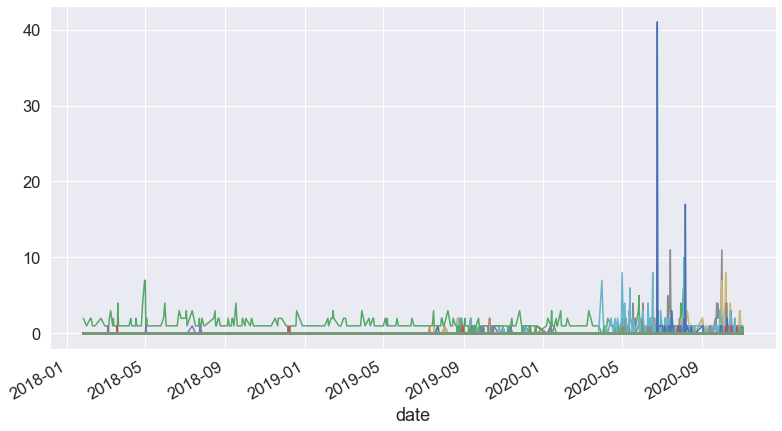

In [67]:
a.plot(figsize=(13, 7))
plt.legend().remove()

### Data Science Students Accessing Web Dev Curriculum

In [68]:
b = ds.loc[ds.page_viewed.isin(wd_curriculum)].groupby(by=['date', 'page_viewed']).user_id.nunique().reset_index().pivot(columns='page_viewed', index='date').fillna(0)

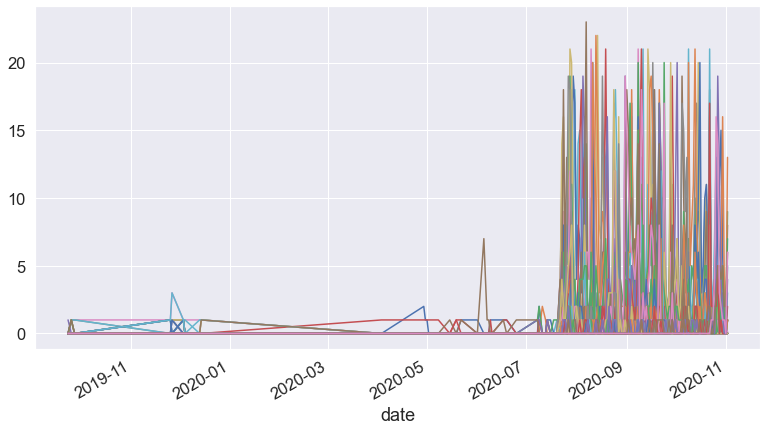

In [69]:
b.plot(figsize=(13, 7))
plt.legend().remove()

This never happened. Codeup recently created their data science program. There is significantly more cross-traffic in 2020 than in previous years.

# 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)? 

In [128]:
df = prep_log_cohort_data(get_log_data(), get_cohort_data(), explore=True)
df = df.loc[df.has_graduated == 1]
remove_pages = ['/', 'toc', 'appendix', 'index.html', 'appendix/documentation'
                'search/search_index.json', 'mkdocs/search_index.json']

# Clean page_viewed to remove logistic pages: Searches, Table of Contents, Appendix
df = df.loc[~df.page_viewed.isin(remove_pages)]
df = df.loc[~(df.cohort_name == 'Staff')]
df.page_viewed = df.page_viewed.replace('content/', '', regex=True)

# Step 1.
# Web Devlopment Cohorts
web_dev_cohorts = df.loc[df.program_id.isin([1, 2, 4]) & (df.end_date <= '2020-06-01') & (df.end_date < df.index)]
# Data Science Cohorts
ds_cohorts = df.loc[(df.program_id == 3) & (df.index > '2020-01-30') & (df.end_date < '2021-01-12')]

### After Graduation: Web Develpoment

In [129]:
web_dev_cohorts.page_viewed.value_counts().nlargest(20)

javascript-i                           2298
spring                                 2117
html-css                               2028
java-i                                 1657
java-iii                               1641
java-ii                                1601
javascript-ii                          1469
search/search_index.json               1351
mysql                                  1300
jquery                                 1203
spring/fundamentals/controllers         963
spring/setup                            927
spring/fundamentals/views               881
spring/fundamentals/repositories        812
html-css/elements                       699
java-i/introduction-to-java             674
java-iii/servlets                       617
java-i/syntax-types-and-variables       617
java-iii/jsp-and-jstl                   612
java-ii/object-oriented-programming     610
Name: page_viewed, dtype: int64

In [130]:
pd.cut(web_dev_cohorts.groupby(by=['user_id']).page_viewed.nunique(), bins=5).value_counts().sort_index()

(0.729, 55.2]     251
(55.2, 109.4]      73
(109.4, 163.6]     33
(163.6, 217.8]      8
(217.8, 272.0]      4
Name: page_viewed, dtype: int64

#### After Graduation: Web Develpoment Review
Recent web dev grads consistently access javascript, spring, html-css, java-i, java-ii, java-iii.

### After Graduation: Data Science

In [131]:
ds_cohorts.page_viewed.value_counts().nlargest(20)

6-regression/1-overview                              672
search/search_index.json                             630
1-fundamentals/modern-data-scientist.jpg             558
1-fundamentals/AI-ML-DL-timeline.jpg                 555
1-fundamentals/1.1-intro-to-data-science             550
3-sql/1-mysql-overview                               480
10-anomaly-detection/1-overview                      392
10-anomaly-detection/AnomalyDetectionCartoon.jpeg    392
4-python/8.4.3-dataframes                            273
4-python/8.4.4-advanced-dataframes                   254
4-python/3-data-types-and-variables                  242
5-stats/4.2-compare-means                            225
4-python/5-functions                                 212
7-classification/6.1-logistic-regression             209
3-sql/7-functions                                    209
appendix/cli-git-overview                            209
5-stats/2-simulation                                 204
5-stats/3-probability-distribut

In [132]:
pd.cut(ds_cohorts.groupby(by=['user_id']).page_viewed.nunique(), bins=5).value_counts().sort_index()

(0.711, 58.8]     14
(58.8, 116.6]      8
(116.6, 174.4]     8
(174.4, 232.2]     9
(232.2, 290.0]     1
Name: page_viewed, dtype: int64

#### After Graduation : Data Science Review
Recent data science grads consistently access regression, fundementals, mysql, anomaly detection, pandas dataframes, stats modules.

# 7. Which lessons are least accessed? 

In [135]:
web_dev_cohorts.loc[~web_dev_cohorts.page_viewed.isin(ds_curriculum)].page_viewed.value_counts().nsmallest(40)

capstone/54                            1
javascript-functions                   1
7.03_Explore                           1
appendix/further-reading/pagination    1
6-regression/3.1-acquire-and-prep      1
10.02.01_ParseText                     1
capstone/52                            1
students                               1
codeup-exercises                       1
students/468/notes                     1
8.01_Acquire                           1
student/create                         1
postwork/dashboard.md                  1
bom-and-dom/dom-events                 1
13.01.02.02_TalkAndListen              1
6.01.02_Acquirecsv                     1
mysql/intro-to-mysql/index.html        1
php                                    1
appendix/postwork/pdf-parser.html      1
capstone-workbook                      1
html-css/elements-i/lists.html         1
introduction-to-matplotlib             1
java-ii/file-op                        1
codeupexercises                        1
html-css/forms-i

Web Development Least Accessed Pages
1. appendix/further-reading/pagination                                      
1. interview-questions
1. javascript-functions
1. html-css/positioning                                     
1. mysql/clauses/limit-order-by

Lesson names were changed for example: java-iii/servelet to java-iii/servelet<strong>s</strong>. Java script control and function modules were accessed the least. Were these modules also renamed? Interview questions page was accessed 1 time. It's an important page now that we're in a remote environment. MySQL limit-order-by was access once. This lesson may have been renamed or included with another module.

In [138]:
ds_cohorts.loc[~ds_cohorts.page_viewed.isin(wd_curriculum)].page_viewed.value_counts().nsmallest(40)

grades                                         1
appendix/coding-challenges/professional        1
database-design                                1
regression/appendix-feature-engineering        1
11-nlp/pos-tagging                             1
4-python/pandas-lesson                         1
classification                                 1
4.2-compare-means                              1
appendix/open_data/www.census.gov              1
11-nlp/entity-labeling                         1
modern-data-scientist.jpg                      1
classification/project-old-exec                1
%20https://github.com/RaulCPena                1
appendix/open_data/www.opensecrets.org         1
classification/svm                             1
8-clustering/hierarchical                      1
regression/least-angle-regression              1
8-clustering/dendogram_sample.jpeg             1
search                                         1
AI-ML-DL-timeline.jpg                          1
A-clustering/project

Data Science Least Accessed Pages
1. appendix/coding-challenges/professional
1. regression/appendix-feature-engineering
1. regression/built-in-datasets
1. 7-classification/confusion-matrix 
1. python/pandas-time-series
1. 9-timeseries/6.2-prophet
1. 12-distributed-ml/6.4-prepare-part-4
1. 5-detecting-with-clustering

The least accessed pages are pages later in a cohort, renamed, or restructured into the current curriculum. Pages in the appendix are rarely viewed.

# 8. Anything else I should be aware of?

In [78]:
# Create datasets filtered by date. Reasoning: Skills that are required may have change slightly in the past
# 3 years. These smaller datasets will be able to capture that information.
wd_2018_Q1Q2 = web_dev_cohorts['2018-01':'2018-06'].groupby(['date', 'cohort_id', 'cohort_name']).page_viewed.size().to_frame()
wd_2018_Q3Q4 = web_dev_cohorts['2018-06':'2018-12'].groupby(['date', 'cohort_id', 'cohort_name']).page_viewed.size().to_frame()
wd_2019_Q1Q2 = web_dev_cohorts['2019-01':'2019-06'].groupby(['date', 'cohort_id', 'cohort_name']).page_viewed.size().to_frame()
wd_2019_Q3Q4 = web_dev_cohorts['2019-06':'2019-12'].groupby(['date', 'cohort_id', 'cohort_name']).page_viewed.size().to_frame()
wd_2020_Q1Q2 = web_dev_cohorts['2020-01':'2020-06'].groupby(['date', 'cohort_id', 'cohort_name']).page_viewed.size().to_frame()
wd_2020_Q3Q4 = web_dev_cohorts['2020-06':'2020-12'].groupby(['date', 'cohort_id', 'cohort_name']).page_viewed.size().to_frame()

# Appendix

In [90]:
df = prep_log_cohort_data(get_log_data(), get_cohort_data())
df = df.loc[~(df.cohort_name == 'Staff')]

# Step 1.
# Web Devlopment Cohorts
web_dev_cohorts = df.loc[df.program_id.isin([1, 2, 4])]

# Data Science Cohorts
ds_cohorts = df.loc[df.program_id == 3]

In [91]:
program_id_1 = web_dev_cohorts.loc[web_dev_cohorts.program_id == 1].groupby(by=['cohort_id',
                                     'cohort_name',
                                     'program_start',
                                     'end_date']
                                ).user_id.nunique()

program_id_1.to_frame().rename(columns={'user_id': 'num_of_users'})

,,,,num_of_users
cohort_id,cohort_name,program_start,end_date,
1,Arches,2014-02-04,2014-04-22,18
2,Badlands,2014-06-04,2014-08-22,3
4,Denali,2014-10-20,2015-01-18,1
5,Everglades,2014-11-18,2015-02-24,1
6,Franklin,2015-02-03,2015-05-26,2
7,Glacier,2015-06-05,2015-10-06,6
8,Hampton,2015-09-22,2016-02-06,5
11,Ike,2016-01-20,2016-05-12,5
12,Joshua,2016-03-08,2016-06-30,5


In [92]:
program_id_2 = web_dev_cohorts.loc[web_dev_cohorts.program_id == 2].groupby(by=['cohort_id',
                                     'cohort_name',
                                     'program_start',
                                     'end_date']
                                ).user_id.nunique()

program_id_2.to_frame().rename(columns={'user_id': 'num_of_users'})

,,,,num_of_users
cohort_id,cohort_name,program_start,end_date,
15,Mammoth,2016-09-26,2017-02-02,5
16,Niagara,2016-10-26,2017-03-09,8
18,Pinnacles,2017-03-27,2017-07-20,14
21,Sequoia,2017-09-27,2018-02-15,28
22,Teddy,2018-01-08,2018-05-17,35
23,Ulysses,2018-03-05,2018-07-19,33
24,Voyageurs,2018-05-29,2018-10-11,34
25,Wrangell,2018-07-23,2018-11-29,26
26,Xanadu,2018-09-17,2019-02-08,20


In [93]:
program_id_4 = web_dev_cohorts.loc[web_dev_cohorts.program_id == 4].groupby(by=['cohort_id',
                                     'cohort_name',
                                     'program_start',
                                     'end_date']
                                ).user_id.nunique()

program_id_4.to_frame().rename(columns={'user_id': 'num_of_users'})

,,,,num_of_users
cohort_id,cohort_name,program_start,end_date,
9,Apollo,2015-03-30,2015-07-29,1


In [94]:
# Unique user id's per Web Dev cohort. Infered as number of students.
wd_students_per_cohort = web_dev_cohorts\
                        .groupby(by=['cohort_id',
                                     'cohort_name',
                                     'program_start',
                                     'end_date']
                                ).user_id.nunique()
wd_students_per_cohort.to_frame().rename(columns={'user_id': 'num_of_users'})

,,,,num_of_users
cohort_id,cohort_name,program_start,end_date,
1,Arches,2014-02-04,2014-04-22,18
2,Badlands,2014-06-04,2014-08-22,3
4,Denali,2014-10-20,2015-01-18,1
5,Everglades,2014-11-18,2015-02-24,1
6,Franklin,2015-02-03,2015-05-26,2
7,Glacier,2015-06-05,2015-10-06,6
8,Hampton,2015-09-22,2016-02-06,5
9,Apollo,2015-03-30,2015-07-29,1
11,Ike,2016-01-20,2016-05-12,5


In [95]:
ds_students_per_cohort = ds_cohorts\
                        .groupby(by=['cohort_id',
                                     'cohort_name',
                                     'program_start',
                                     'end_date']
                                ).user_id.nunique()
ds_students_per_cohort.to_frame().rename(columns={'user_id': 'num_of_users'})

,,,,num_of_users
cohort_id,cohort_name,program_start,end_date,
34,Bayes,2019-08-19,2020-01-30,23
55,Curie,2020-02-03,2020-07-07,21
59,Darden,2020-07-13,2021-01-12,28
